# Numerical Methods Mini‑Lab (Jupyter Notebook)

This notebook contains **three programming tasks**:

1. **ODEs (Projectile motion)** solved with **Euler's method** and a **finite-difference (FD) time discretization**.
2. **1D Diffusion equation** solved in Python using an explicit finite‑difference scheme, with **reflective** and **absorbing** boundaries.
3. A **simple fluid mechanics** problem (plane Poiseuille flow) explained and simulated with both an **analytic solution** and an **FD linear system**.

Each section includes Markdown explanation and the corresponding code.


In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Plotting defaults (feel free to tweak)
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True


# 1) ODEs: Projectile Motion (Euler Method + Finite Differences)

A projectile in 2D under uniform gravity (no air drag).

The governing equations are:

$$
\dot{x} = v_x, \qquad \dot{y} = v_y
$$

$$
\dot{v}_x = 0, \qquad \dot{v}_y = -g
$$

---

## 1.1 Euler’s Method (Explicit)

Let the state vector be

$$
\mathbf{s} = (x,\, y,\, v_x,\, v_y)
$$

and let the timestep be $\Delta t$.

Euler’s explicit update rule is:

$$
\mathbf{s}_{n+1} = \mathbf{s}_n + \Delta t \, f(\mathbf{s}_n)
$$

where $f(\mathbf{s})$ represents the right-hand side of the ODE system.

---

### Accuracy Note

Euler’s method is **first-order accurate in time**.  
Reducing the timestep $\Delta t$ by a factor of 2 typically reduces the global error by approximately a factor of 2.


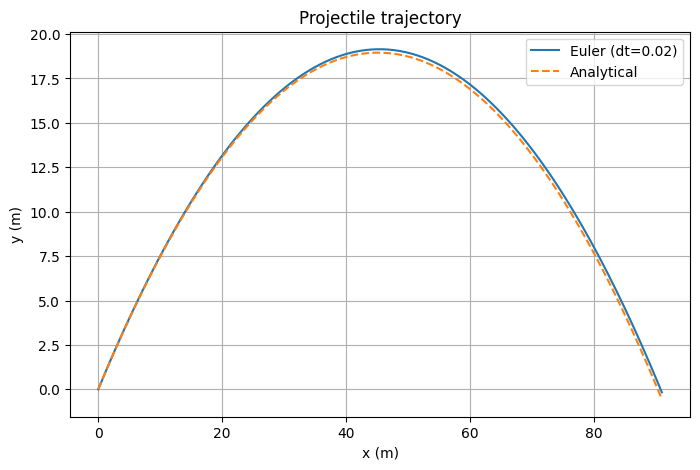

In [9]:
def euler_projectile(x0, y0, vx0, vy0, g=9.81, dt=0.01, t_end=5.0):
    n_steps = int(np.ceil(t_end / dt)) + 1
    t = np.zeros(n_steps)
    x = np.zeros(n_steps)
    y = np.zeros(n_steps)
    vx = np.zeros(n_steps)
    vy = np.zeros(n_steps)

    x[0], y[0], vx[0], vy[0] = x0, y0, vx0, vy0

    for n in range(n_steps - 1):
        t[n+1] = t[n] + dt

        # derivatives
        dxdt = vx[n]
        dydt = vy[n]
        dvxdt = 0.0
        dvydt = -g

        # Euler update
        x[n+1]  = x[n]  + dt * dxdt
        y[n+1]  = y[n]  + dt * dydt
        vx[n+1] = vx[n] + dt * dvxdt
        vy[n+1] = vy[n] + dt * dvydt

        # stop when it hits the ground (y < 0)
        if y[n+1] < 0 and n > 0:
            t = t[:n+2]; x = x[:n+2]; y = y[:n+2]; vx = vx[:n+2]; vy = vy[:n+2]
            break

    return t, x, y, vx, vy


g = 9.81
speed = 30.0         # m/s
angle_deg = 40.0     # degrees
angle = np.deg2rad(angle_deg)

x0, y0 = 0.0, 0.0
vx0, vy0 = speed*np.cos(angle), speed*np.sin(angle)

dt = 0.02
t, x, y, vx, vy = euler_projectile(x0, y0, vx0, vy0, g=g, dt=dt, t_end=10.0)

# Analytical solution (same time grid)
x_exact = x0 + vx0 * t
y_exact = y0 + vy0 * t - 0.5 * g * t**2

plt.plot(x, y, label=f"Euler (dt={dt})")
plt.plot(x_exact, y_exact, "--", label="Analytical")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Projectile trajectory")
plt.legend()
plt.show()


### 1.2 Finite-difference time discretization (second-order ODE)

For the vertical motion we can write a **second-order ODE**:

$$
y''(t) = -g
$$

with initial conditions $y(0)=y_0$ and $y'(0)=v_{y0}$.

A classic finite-difference (FD) discretization for the second derivative uses a centered difference:

$$
\frac{y_{n+1}-2y_n+y_{n-1}}{\Delta t^2} \approx y''(t_n)
$$

So the recurrence becomes:

$$
y_{n+1} = 2y_n - y_{n-1} - g\,\Delta t^2
$$

To start the recurrence, we need $y_1$. A convenient choice is a Taylor step:

$$
y_1 = y_0 + v_{y0}\Delta t - \tfrac12 g\Delta t^2
$$

This FD scheme is **second-order accurate** in time for this constant-acceleration problem.


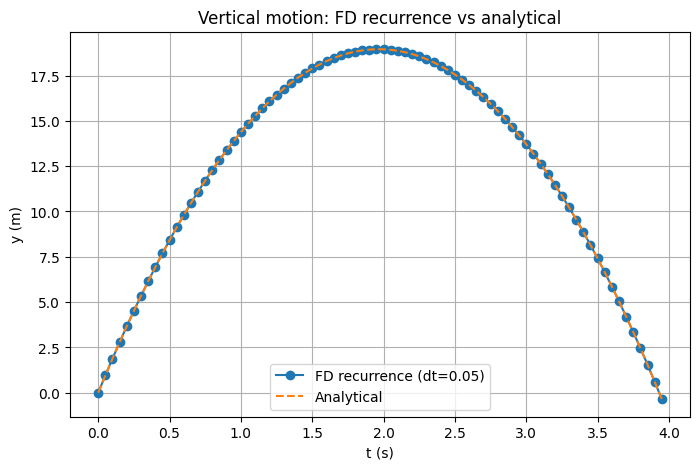

In [10]:
def fd_vertical_motion(y0, vy0, g=9.81, dt=0.01, t_end=5.0):
    n_steps = int(np.ceil(t_end / dt)) + 1
    t = np.linspace(0.0, dt*(n_steps-1), n_steps)
    y = np.zeros(n_steps)

    y[0] = y0
    # Start value using Taylor expansion
    y[1] = y0 + vy0*dt - 0.5*g*dt**2

    for n in range(1, n_steps-1):
        y[n+1] = 2*y[n] - y[n-1] - g*dt**2
        if y[n+1] < 0 and n > 1:
            t = t[:n+2]
            y = y[:n+2]
            break

    return t, y


# Compare FD y(t) with analytical
dt = 0.05
t_fd, y_fd = fd_vertical_motion(y0=0.0, vy0=vy0, g=g, dt=dt, t_end=10.0)
y_exact_fd = 0.0 + vy0*t_fd - 0.5*g*t_fd**2

plt.plot(t_fd, y_fd, "o-", label=f"FD recurrence (dt={dt})")
plt.plot(t_fd, y_exact_fd, "--", label="Analytical")
plt.xlabel("t (s)")
plt.ylabel("y (m)")
plt.title("Vertical motion: FD recurrence vs analytical")
plt.legend()
plt.show()


### 1.3 Error vs timestep (Euler)

We'll quantify the error at the **final simulated time** by comparing Euler with the analytical solution.
For a first-order method like Euler, the error should scale approximately like $$\mathcal{O}(\Delta t)$$


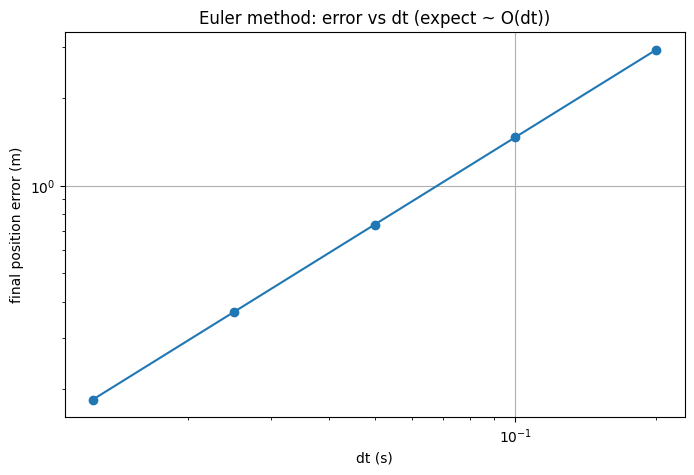

dt= 0.2000  error=  2.943000 m
dt= 0.1000  error=  1.471500 m
dt= 0.0500  error=  0.735750 m
dt= 0.0250  error=  0.367875 m
dt= 0.0125  error=  0.183938 m


In [11]:
def euler_error_vs_dt(dts, t_end=3.0):
    errs = []
    for dt in dts:
        t, x, y, vx, vy = euler_projectile(x0, y0, vx0, vy0, g=g, dt=dt, t_end=t_end)
        tf = t[-1]
        x_ex = x0 + vx0 * tf
        y_ex = y0 + vy0 * tf - 0.5*g*tf**2
        err = np.sqrt((x[-1]-x_ex)**2 + (y[-1]-y_ex)**2)
        errs.append(err)
    return np.array(errs)

dts = np.array([0.2, 0.1, 0.05, 0.025, 0.0125])
errs = euler_error_vs_dt(dts, t_end=3.0)

plt.loglog(dts, errs, "o-")
plt.xlabel("dt (s)")
plt.ylabel("final position error (m)")
plt.title("Euler method: error vs dt (expect ~ O(dt))")
plt.show()

for dt, e in zip(dts, errs):
    print(f"dt={dt:>7.4f}  error={e:>10.6f} m")


## 2) PDE: 1D Diffusion Equation (Reflective / Absorbing Walls)

Solving the 1D diffusion equation:

$$
\frac{\partial u}{\partial t} = D\,\frac{\partial^2 u}{\partial x^2}
$$

where $u(x,t)$ could represent concentration or density, and $D$ is the diffusion coefficient.

---

### 2.1 Discretization (FTCS scheme)

Let $x_i = i\Delta x$ and $t^n = n\Delta t$.  
The explicit forward-time centered-space (FTCS) update is:

$$
u_i^{n+1} = u_i^n + r\,(u_{i+1}^n - 2u_i^n + u_{i-1}^n),
\qquad
r = \frac{D\Delta t}{\Delta x^2}.
$$

**Stability:** for FTCS in 1D, a standard condition is approximately $r \le \tfrac{1}{2}$.

---

### 2.2 Boundary conditions

- **Absorbing walls (Dirichlet):** $u(0,t)=u(L,t)=0$.
- **Reflective walls (Neumann):** zero flux $\partial u/\partial x = 0$ at the boundaries.

Strating from a **central density bump** and then evolve it.


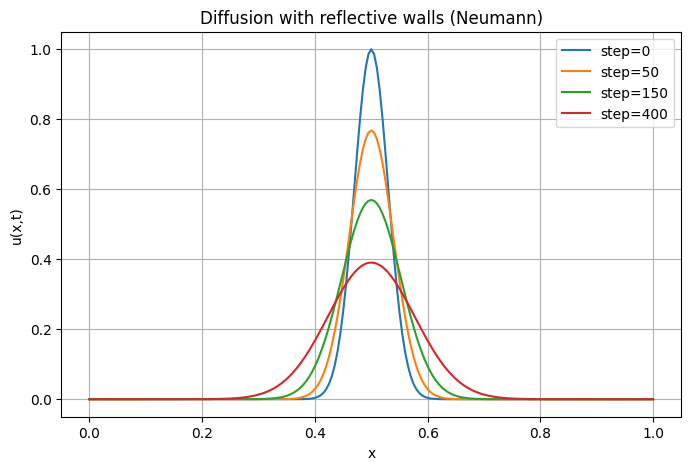

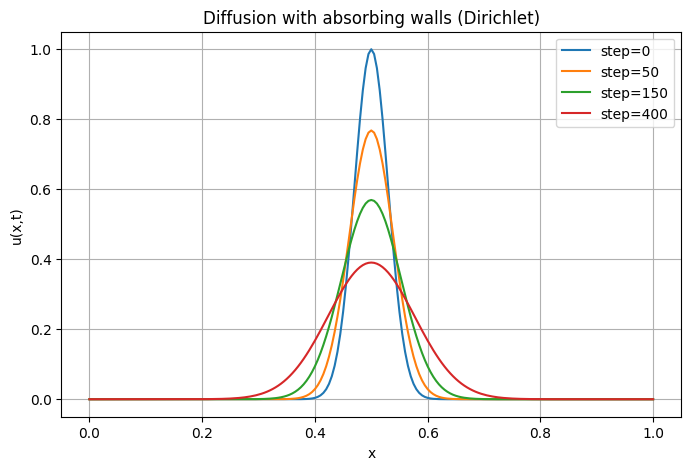

In [12]:
def diffuse_1d(u0, D, dx, dt, steps, bc="reflective"):
    u = u0.astype(float).copy()
    N = u.size
    r = D * dt / dx**2
    if r > 0.5:
        print(f"WARNING: r = {r:.3f} > 0.5 (FTCS may be unstable).")

    u_hist = np.zeros((steps+1, N), dtype=float)
    u_hist[0] = u

    for n in range(steps):
        un = u.copy()

        # interior update
        u[1:-1] = un[1:-1] + r * (un[2:] - 2*un[1:-1] + un[:-2])

        # boundary conditions
        if bc == "absorbing":
            u[0] = 0.0
            u[-1] = 0.0
        elif bc == "reflective":
            # Neumann: du/dx=0 -> mirror values
            u[0] = u[1]
            u[-1] = u[-2]
        else:
            raise ValueError("bc must be 'reflective' or 'absorbing'")

        u_hist[n+1] = u

    return u_hist


# Setup domain and initial condition
L = 1.0
N = 201
x = np.linspace(0, L, N)
dx = x[1] - x[0]

D = 0.01
dt = 0.25 * dx**2 / D   # r = 0.25 (stable)
steps = 400

# Initial condition: narrow Gaussian centered in the domain
x0 = 0.5 * L
sigma = 0.03
u0 = np.exp(-0.5 * ((x - x0)/sigma)**2)

u_ref = diffuse_1d(u0, D=D, dx=dx, dt=dt, steps=steps, bc="reflective")
u_abs = diffuse_1d(u0, D=D, dx=dx, dt=dt, steps=steps, bc="absorbing")

# Plot snapshots
snapshot_steps = [0, 50, 150, 400]

for k in snapshot_steps:
    plt.plot(x, u_ref[k], label=f"step={k}")
plt.title("Diffusion with reflective walls (Neumann)")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.show()

for k in snapshot_steps:
    plt.plot(x, u_abs[k], label=f"step={k}")
plt.title("Diffusion with absorbing walls (Dirichlet)")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.show()


### 2.3 Simple animation helper



In [13]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots()
line, = ax.plot(x, u_ref[0])
ax.set_ylim(0, 1.1*np.max(u0))
ax.set_title("Diffusion (reflective walls)")
ax.set_xlabel("x"); ax.set_ylabel("u")

def update(frame):
    line.set_ydata(u_ref[frame])
    ax.set_title(f"Diffusion (reflective) - step {frame}/{steps}")
    return line,

anim = FuncAnimation(fig, update, frames=range(0, steps+1, 5), interval=50, blit=True)
plt.close(fig)
HTML(anim.to_jshtml())


Output hidden; open in https://colab.research.google.com to view.

## 3) Fluid Mechanics: Plane Poiseuille Flow (Analytic + Finite Difference)

A classic simple fluid mechanics problem is **laminar flow between two stationary parallel plates** (plane Poiseuille flow).

Assume:
- incompressible Newtonian fluid
- steady, fully developed flow
- velocity is only in the $x$ direction: $u=u(y)$
- constant pressure gradient $\mathrm{d}p/\mathrm{d}x$

Under these assumptions, the Navier–Stokes equations reduce to:

$$
\mu \frac{\mathrm{d}^2 u}{\mathrm{d}y^2} = \frac{\mathrm{d}p}{\mathrm{d}x}
$$

with **no-slip** at the plates (located at $y=\pm h$):

$$
u(-h)=0,\qquad u(h)=0.
$$

---

### 3.1 Analytical solution

Integrating twice gives the parabolic profile:

$$
u(y) = \frac{1}{2\mu}\frac{\mathrm{d}p}{\mathrm{d}x}(y^2-h^2).
$$

If $\mathrm{d}p/\mathrm{d}x < 0$, the flow is in the positive $x$ direction.

---

### 3.2 Finite difference solution

Discretize $y$ and approximate the second derivative:

$$
\frac{u_{i+1}-2u_i+u_{i-1}}{\Delta y^2} \approx u''(y_i).
$$

This yields a tridiagonal linear system for interior points.


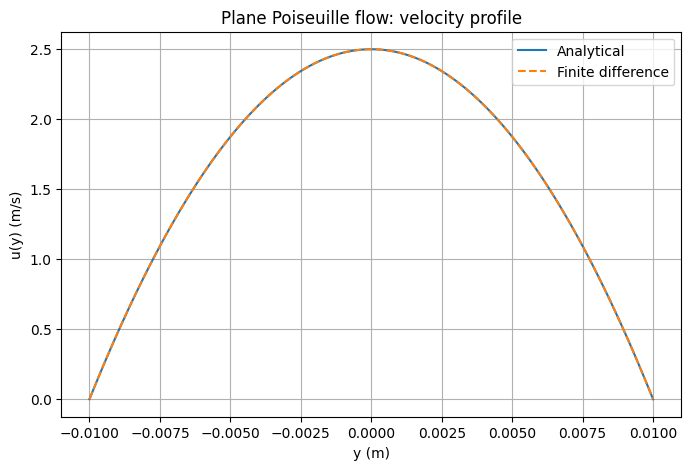

u_max   = 2.500000e+00 m/s
u_avg   = 1.666551e+00 m/s
Q/width = 3.333102e-02 m^2/s


/tmp/ipython-input-2151233712.py:45: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Q_per_width = np.trapz(u_an, y)  # m^2/s (flow rate per unit width)


In [14]:
def plane_poiseuille_analytic(y, h, mu, dpdx):
    return (dpdx/(2*mu)) * (y**2 - h**2)


def plane_poiseuille_fd(h, mu, dpdx, N=101):
    y = np.linspace(-h, h, N)
    dy = y[1] - y[0]

    # Solve for interior points i=1..N-2
    n_int = N - 2
    A = np.zeros((n_int, n_int), dtype=float)
    b = np.full(n_int, dpdx/mu, dtype=float)  # because u'' = dpdx/mu

    for i in range(n_int):
        A[i, i] = -2.0 / dy**2
        if i - 1 >= 0:
            A[i, i-1] = 1.0 / dy**2
        if i + 1 < n_int:
            A[i, i+1] = 1.0 / dy**2

    u_int = np.linalg.solve(A, b)
    u = np.zeros(N, dtype=float)
    u[1:-1] = u_int
    return y, u


# Parameters
h = 0.01          # half-gap (m)
mu = 1.0e-3       # dynamic viscosity (Pa·s) ~ water
dpdx = -50.0      # pressure gradient (Pa/m), negative drives flow +x

N = 121
y, u_fd = plane_poiseuille_fd(h=h, mu=mu, dpdx=dpdx, N=N)
u_an = plane_poiseuille_analytic(y=y, h=h, mu=mu, dpdx=dpdx)

plt.plot(y, u_an, label="Analytical")
plt.plot(y, u_fd, "--", label="Finite difference")
plt.xlabel("y (m)")
plt.ylabel("u(y) (m/s)")
plt.title("Plane Poiseuille flow: velocity profile")
plt.legend()
plt.show()

u_max = np.max(u_an)
Q_per_width = np.trapz(u_an, y)  # m^2/s (flow rate per unit width)
u_avg = Q_per_width / (2*h)

print(f"u_max   = {u_max:.6e} m/s")
print(f"u_avg   = {u_avg:.6e} m/s")
print(f"Q/width = {Q_per_width:.6e} m^2/s")


In [21]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive



Mounted at /content/drive
 20200519_062616.jpg
'2024-07-09T06_54_57.011Z-[ISRO] Bharatiya Antariksh Hackathon 24 _ Idea Submission Template.gslides'
 22B0007.pdf_compressed.pdf
'23-Nov-2022 at 9:14:02 AM.pdf'
 423B1988-00BA-453A-B586-A6902D012152.jpeg
 aaa.png
 aa.csv
 aa.gsheet
'AE 244 Assignment III.gsheet'
'[Aerodynamics]-[22b0007].pdf'
'AeRoVe_Assignment (1).pdf'
'airfoil (1).csv'
'airfoil (1).gsheet'
'airfoil (2) (1).csv'
'airfoil (2).csv'
'airfoil (2).gsheet'
'airfoil (3).csv'
'airfoil (3).gsheet'
'airfoil (4).csv'
'airfoil (4).gsheet'
 Animation
'Animation (1)'
'apa-zfru-rhf – 17 Apr 2024.pdf'
 AssignmentLSAR.mlx
'Bill Of Materials.gsheet'
 bots_compare.mp4
 Classroom
'Cl Cd.csv'
'Cl Cd.gsheet'
'Colab Notebooks'
 Component_listing.gsheet
 Component_Listing_Soaron.gsheet
'contacts - contacts.csv.gsheet'
'coordinates (1).gsheet'
 coordinates.gsheet
 coordinates.txt
'Copy of All_ETS_Material_GregWords.gsheet'
 Curriculum_Vitae.pdf
 CV
 CV_1
 CV_2
'data (1)'
 data.gsheet
 DH307.gdoc